In [1]:
# STEP1 : 주가 데이터 불러오기
# STEP2 : 우량주 선정
# STEP3 : 우량주면 매수
# STEP4 : 매도 타이밍 구현

# 1. 라이브러리 선언

In [2]:
import FinanceDataReader as web

from datetime import date, timedelta

import matplotlib.pyplot as plt

import datetime

import numpy as np

import seaborn as sns

import urllib.parse

import pandas as pd

from matplotlib import font_manager, rc

import platform

from bs4 import BeautifulSoup 

import requests 


MARKET_CODE_DICT = {

    'kospi': 'stockMkt',

    'kosdaq': 'kosdaqMkt',

    'konex': 'konexMkt'

    
}

DOWNLOAD_URL = 'https://kind.krx.co.kr/corpgeneral/corpList.do'

def zeroFill(columnValue):

    columnValue = str(columnValue)

    outValue = columnValue.zfill(6)

    return outValue

def get_stock_codes(market=None, delisted=False):

    params = {'method': 'download'}

    if market.lower() in MARKET_CODE_DICT:

        ## marketType 키 추가

        params['marketType'] = MARKET_CODE_DICT[market]

        print(market.lower()+" market key is exist")

    else:

        print("invalid market")

    # make url  key=value & key = value

    params_string = urllib.parse.urlencode(params)

    print(params_string)
    request_url = DOWNLOAD_URL+"?"+params_string
    
    print(request_url)

    df = pd.read_html(request_url)[0]
    

    df["종목코드"] = df.종목코드.apply(zeroFill)
#     df["종목코드"] = df.종목코드.map('{:06d}'.format) # 동일 결과
 
    return df

In [3]:
# 업체의 재무재표 불러오는 로직
def get_stock_info(stockName=None):
    
    try:
        url = 'https://finance.naver.com/item/main.nhn'
        stocks = get_stock_codes('kospi')
        target_stock = stocks.loc[stocks['회사명'] == stockName ]
        stock_code = target_stock.iloc[0]['종목코드']

        param_code = {'code': stock_code}

        param_string = urllib.parse.urlencode(param_code)

        request_url = url+"?"+param_string
        print(request_url)




        table_df_list = pd.read_html(request_url, encoding='euc-kr')    # 한글이 깨짐. utf-8도 깨짐. 그래서 'euc-kr'로 설정함  
        table_df = table_df_list[3]
    except Exception as e:
        print(e)
    return table_df

# 우량주 판별 로직 10단계

# 1. 1/PER > (AAA회사채 시장수익률)
# 2. 현재 PER < (5년평균 PER) * 0.4
# 3. 배당수익률 > (AAA회사채 시장수익률) * 0.67
# 4. PBR < 0.67
# 5. 0 < 주가/순유동자산 < 0.67
# 6. 0 < 부채비율 < 100%
# 7. 유동비율 > 200%
# 8. 부채 / 순유동자산 < 2
# 9. 과거 10년간 EPS 연복리 증가율 > 7%
# 10. 과거 10년간 순이익 < 0 횟수 2회 이하

def blue_chip_stock(stockName):
    stock_info = get_stock_info(stockName)
    
    # 2번 현재 PER < (5년평균 PER) * 0.4
    if (stock_info.xs('최근 분기 실적', axis=1).xs(10,axis=0)[-1] < stock_info.xs('최근 연간 실적', axis=1).xs(10,axis=0).mean()*0.4):
        
        # 4 번 PBR < 0.67
        cnt = 0
        for i in range(len(list(stock_info.xs('최근 연간 실적',axis=1).xs(12,axis=0) ))):
                      
            if(list(stock_info.xs('최근 연간 실적',axis=1).xs(12,axis=0))[i] < 0.67):
                cnt += 1
                
        if(cnt == 0):
            
            
            # 10. 과거 10년간 순이익 < 0 횟수 2회 이하
            for j in range(len( list(stock_info.xs('최근 연간 실적',axis=1).xs(4,axis=0) ))):
                cnt = 0
                if(list(stock_info.xs('최근 연간 실적',axis=1).xs(4,axis=0)[j]) < 0):
                    cnt += 1
                   
            if(cnt <= 2):
                   
                   # 9. 과거 10년간 EPS 연복리 증가율 > 7% 
                trueOrFalse = []
                cnt = 0
                for i in range(len (list(stock_info.xs('최근 연간 실적', axis=1).xs(9,axis=0)))-1 ):
                    if ( list(stock_info.xs('최근 연간 실적', axis=1).xs(9,axis=0))[i]*0.07 < list(stock_info.xs('최근 연간 실적', axis=1).xs(9,axis=0))[i+1] ):

                        trueOrFalse.append(True)
                    else :
                        trueOrFalse.append(False)
                        cnt +=1
                if(cnt == 0):
                    print("우량주 입니다")
                   
                else:
                    print(stockName + "은(는) 우량주가 아닙니다") # 9번 끝
                   
                   
            else:
                print(stockName + "은(는) 우량주가 아닙니다") # 10번 끝
                   
                              
        else:
            print(stockName + "은(는) 우량주가 아닙니다")  # 4번 끝
    
        
    else:
        print(stockName + "는(은) 우량주가 아닙니다" )  # 2번 끝

In [4]:
blue_chip_stock('이마트')

kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt
https://finance.naver.com/item/main.nhn?code=139480
이마트는(은) 우량주가 아닙니다


In [5]:
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
else:
    pass
print(platform.system())

Windows


In [6]:
def predict_stock(stockName,time):
    # 예측 로직 구현.
    if blue_chip_stock(stockName) is True:
        # 주가 종목 추출
        stocks = get_stock_codes('kospi')
        target_name = stockName
        target_stock = stocks.loc[stocks['회사명'] == target_name]
        stock_code = target_stock.iloc[0]['종목코드']
        
        # 시간 설정 주가 차트 불러오기
        end = date.today()
        start = date.today() - timedelta(time)
        stockName = web.DataReader(stock_code, start, end)
        

In [117]:
predict_stock('카카오',365)

kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt
https://finance.naver.com/item/main.nhn?code=035720
카카오는(은) 우량주가 아닙니다


In [7]:
# 주가 예측 할 종목 추출
stocks = get_stock_codes('kospi')

target_name = '카카오'

target_stock = stocks.loc[stocks['회사명'] == target_name ]

stock_name = target_stock.iloc[0]['회사명']
stock_code = target_stock.iloc[0]['종목코드']
print(stock_name)
print(stock_code)





## 아래와 동일 한 로직. 시간은 다름.
# %matplotlib inline
# plt.figure(figsize=(15,9))
# today = date.today()
# startday = date(2021,5,1)
# endday = today
# Kakao = web.DataReader(stock_code, startday, endday)
# Kakao

## 선정 종목 주가 차트 불러오기
time = 1825  # 5년으로 설정
end = date.today()
start = date.today() - timedelta(time) 

KAKAO_STOCK = web.DataReader(stock_code, start, end)
KAKAO_STOCK

kospi market key is exist
method=download&marketType=stockMkt
https://kind.krx.co.kr/corpgeneral/corpList.do?method=download&marketType=stockMkt
카카오
035720


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2016-06-20,18365,19048,18365,19048,301386,0.039454
2016-06-21,19108,19208,18786,18827,184809,-0.011602
2016-06-22,18726,19007,18726,18907,139412,0.004249
2016-06-23,18826,18866,18645,18706,186812,-0.010631
2016-06-24,18967,18987,17722,18305,713158,-0.021437
...,...,...,...,...,...,...
2021-06-14,136000,143000,136000,142500,6240394,0.051661
2021-06-15,143500,144500,140500,144500,4950329,0.014035
2021-06-16,144000,146000,142500,143000,4996272,-0.010381


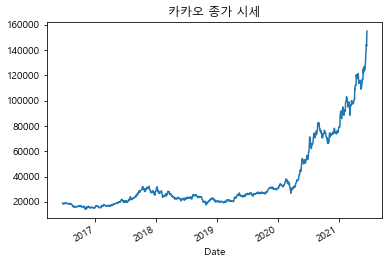

In [8]:
# 종가 시세 차트.
KAKAO_STOCK['Close'].plot()
# print(plt.style.available)
# plt.style.use(['fivethirtyeight'])
plt.title(stock_name+" 종가 시세")
plt.show()

In [19]:
# 5일 20일 60일 120일 기준 이동평균선

KAKAO_STOCK["MA_5"] = KAKAO_STOCK["Close"].rolling(window=5).mean()
KAKAO_STOCK["MA_20"] = KAKAO_STOCK["Close"].rolling(window=20).mean()
KAKAO_STOCK["MA_60"] = KAKAO_STOCK["Close"].rolling(window=60).mean()
KAKAO_STOCK["MA_120"] = KAKAO_STOCK["Close"].rolling(window=120).mean()
KAKAO_STOCK

,Open,High,Low,Close,Volume,Change,MA_5,MA_20,MA_60,MA_120
Date,,,,,,,,,,
2016-06-17,18405,18545,18204,18325,253700,0.001093,NaN,NaN,NaN,NaN
2016-06-20,18365,19048,18365,19048,301386,0.039454,NaN,NaN,NaN,NaN
2016-06-21,19108,19208,18786,18827,184809,-0.011602,NaN,NaN,NaN,NaN
2016-06-22,18726,19007,18726,18907,139412,0.004249,NaN,NaN,NaN,NaN
2016-06-23,18826,18866,18645,18706,186812,-0.010631,18762.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-06-10,130000,135000,129500,133500,5564011,0.034884,128200.0,120900.0,113416.933333,101477.275000
2021-06-11,134500,136500,132000,135500,3674400,0.014981,130500.0,122200.0,114052.816667,101985.900000
2021-06-14,136000,143000,136000,142500,6240394,0.051661,133800.0,123875.0,114761.883333,102551.183333


C:\Users\kopo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\kopo\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


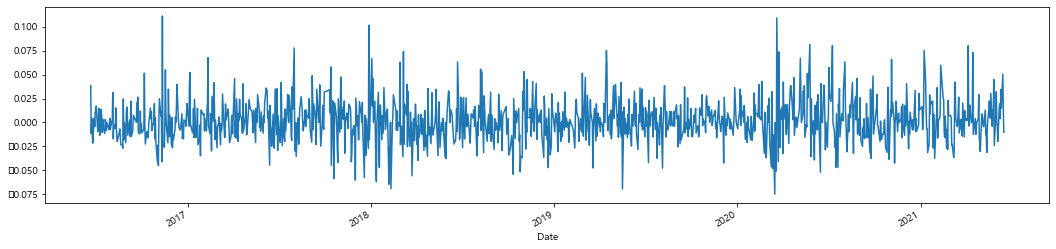

In [20]:
# 수익률 계산로직 부분.

KAKAO_STOCK['Rate'] = np.log( KAKAO_STOCK['Close'].astype(float) / KAKAO_STOCK['Close'].shift(1).astype(float))

KAKAO_STOCK

# 수익률..계산..차트
KAKAO_STOCK["Rate"].plot(figsize=(18,4))
plt.show()

주요재무정보  최근 연간 실적                                 최근 분기 실적            \
       주요재무정보   2018.12   2019.12   2020.12 2021.12(E)   2020.03   2020.06   
       주요재무정보    IFRS연결    IFRS연결    IFRS연결     IFRS연결    IFRS연결    IFRS연결   
0         매출액  24170.00  30701.00  41568.00   56775.00   8684.00   9529.00   
1        영업이익    729.00   2068.00   4559.00    7845.00    882.00    978.00   
2       당기순이익    159.00  -3419.00   1734.00    8630.00    799.00   1452.00   
3       영업이익률      3.02      6.73     10.97      13.82     10.16     10.26   
4        순이익률      0.66    -11.14      4.17      15.20      9.20     15.24   
5   ROE(지배주주)      1.04     -5.81      2.70      11.77     -4.73     -2.67   
6        부채비율     41.45     52.21     60.94        NaN     57.01     49.86   
7        당좌비율    146.51    127.98    162.77        NaN    134.03    144.53   
8         유보율  12219.62  12027.79  13881.01        NaN  12587.68  13665.91   
9      EPS(원)    123.00   -717.00    355.00    1770.00    179.00    320.00   
10     PER(배)    168.01    -42.82    219.25      81.64    -52.50   -152.84   
11     BPS(원)  12979.00  12746.00  14647.00   16327.00  13108.00  14073.00   
12     PBR(배)      1.59      2.41      5.32       8.85      2.37      3.80   
13   주당배당금(원)     25.00     25.00     30.00     106.00       NaN       NaN   
14   시가배당률(%)      0.12      0.08      0.04        NaN       NaN       NaN   
15    배당성향(%)     20.99     -3.46      8.29        NaN       NaN       NaN   

                                             
     2020.09   2020.12   2021.03 2021.06(E)  
      IFRS연결    IFRS연결    IFRS연결     IFRS연결  
0   11004.00  12351.00  12580.00   13461.00  
1    1202.00   1497.00   1575.00    1789.00  
2    1437.00  -1955.00   2399.00    1985.00  
3      10.92     12.12     12.52      13.29  
4      13.06    -15.83     19.07      14.75  
5      -1.33      2.70      5.00        NaN  
6      50.37     60.94     71.56        NaN  
7     148.86    162.77    163.55        NaN  
8   14373.52  13881.01  14508.10        NaN  
9     290.00   -428.00    506.00     445.00  
10   -404.46    219.25    144.96     324.73  
11  14910.00  14647.00  15428.00        NaN  
12      4.89      5.32      6.46        NaN  
13       NaN       NaN       NaN        NaN  
14       NaN       NaN       NaN        NaN  
15       NaN       NaN       NaN        NaN